当我们找工作时，拉勾网是一个不错的网站。今天我们抓取一些拉勾网的招聘数据，来分析`数据分析`岗位的一些市场招聘情况、薪资情况等，以便于大家后续对找数据分析相关岗位时有一个清晰的认识。

## 分析请求

这里我们搜索关键词：`数据分析`，并且限定工作地点：北京。

![](../image/07-拉勾网搜索截图.png)

然后我们通过浏览器的F12快捷键打开开发者调试工具，在`NetWork`标签下选择`XHR`，可以看到有一个请求是 `positionAjax.json`，查看下Response可以看到，所有的招聘信息都是通过这个API接口返回的。

可以看到完整的URL是`https://www.lagou.com/jobs/positionAjax.json?city=%E5%8C%97%E4%BA%AC&needAddtionalResult=false`，并且是 POST 请求。

可以看出来，城市地点的限定是通过URL中的`city`参数控制的。

![](../image/07-NetWork-1.png)

那我们的搜索关键词和页数是怎么控制的呢？仔细研究下，发现POST请求时还发送了一个表单信息，里面包含了搜索的关键字参数`kd`以及控制页数参数`pn`。

![](../image/07-NetWork-2.png)


## 爬取数据

分析了请求，知道了数据的传输方式，现在我们来写程序来爬取下第一页的数据。

In [1]:
import pandas as pd
import requests
import time
from collections import defaultdict

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36",
    "Referer": "https://www.lagou.com/jobs/list_%E6%95%B0%E6%8D%AE%E5%88%86%E6%9E%90?city=%E5%8C%97%E4%BA%AC&cl=false&fromSearch=true&labelWords=&suginput=",
}

cookies = {
    "Cookie": "JSESSIONID=ABAAABAAADEAAFI3E2AE80419BA8FFB6F5FFB49D1573C34; _ga=GA1.2.260226169.1531815206; user_trace_token=20180717161326-47e61066-8999-11e8-9c54-525400f775ce; LGUID=20180717161326-47e613e7-8999-11e8-9c54-525400f775ce; _gid=GA1.2.1025242393.1534486196; Hm_lvt_4233e74dff0ae5bd0a3d81c6ccf756e6=1534486196; TG-TRACK-CODE=index_search; fromsite=translate.baiducontent.com; utm_source=""; index_location_city=%E5%8C%97%E4%BA%AC; Hm_lpvt_4233e74dff0ae5bd0a3d81c6ccf756e6=1534650094; _gat=1; LGSID=20180819114134-c4f1bc52-a361-11e8-a9f8-5254005c3644; PRE_UTM=; PRE_HOST=; PRE_SITE=https%3A%2F%2Fwww.lagou.com%2Fjobs%2Flist_%3FlabelWords%3D%26fromSearch%3Dtrue%26suginput%3D; PRE_LAND=https%3A%2F%2Fwww.lagou.com%2Fjobs%2Flist_%25E6%2595%25B0%25E6%258D%25AE%25E5%2588%2586%25E6%259E%2590%3Fcity%3D%25E5%258C%2597%25E4%25BA%25AC%26cl%3Dfalse%26fromSearch%3Dtrue%26labelWords%3D%26suginput%3D; LGRID=20180819114134-c4f1bf1a-a361-11e8-a9f8-5254005c3644; SEARCH_ID=c5acefc2c73649dea43d17ec5f57b810"
}


# 爬取每一页的数据
def crawl_lagou_data(city, kd, pn=1):
    url = "https://www.lagou.com/jobs/positionAjax.json?city={city}&needAddtionalResult=false".format(city=city)
    
    data = {
    "first": True,
    "pn": pn,
    "kd": kd
    }
    rp = requests.post(url, headers=headers, cookies=cookies, data=data)
    
    result = rp.json()
    if not result["success"]:
        print("pn: %s, 抓取失败" % pn)
        return []
    return result["content"]["positionResult"]["result"]

result = defaultdict(list)


for i in range(1, 50):
    print("正在抓取第 %s 页" %i, end="\r")
    job_infos = crawl_lagou_data("北京", "数据分析", i)
    for job_info in job_infos:
        result["positionId"].append(job_info.get("positionId"))
        result["city"].append(job_info.get("city"))
        result["companyLabelList"].append(",".join(job_info.get("companyLabelList")))
        result["companyShortName"].append(job_info.get("companyShortName"))
        result["companySize"].append(job_info.get("companySize"))
        result["district"].append(job_info.get("district"))
        result["education"].append(job_info.get("education"))
        result["salary"].append(job_info.get("salary"))
        result["workYear"].append(job_info.get("workYear"))
        result["financeStage"].append(job_info.get("financeStage"))
        result["subwayline"].append(job_info.get("subwayline"))     
    print("抓取第 %s 页成功" %i, end="\r")
    time.sleep(10)
df = pd.DataFrame(result)

pn: 6, 抓取失败
pn: 12, 抓取失败
pn: 18, 抓取失败
pn: 24, 抓取失败
pn: 30, 抓取失败


由于拉勾网的反爬虫机制做得较好，这里设置的每次抓取休息间隔 10s 会有部分抓取失效，如果不考虑抓取效率的话，可以适当增加这个时间。

## 分析数据

首先先根据 `positionId` 字段进行一次去重。

In [2]:
print("去重前数据：{}".format(df.shape))
df = df.drop_duplicates(subset=["positionId"])
print("去重后数据：{}".format(df.shape))

去重前数据：(660, 11)
去重后数据：(657, 11)


In [3]:
df.to_csv('df.csv', index=False)

### 哪些公司的招聘需求最多呢？

我们先来统计下招聘岗位数量前 10 的公司。

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #用来正常显示中文标签
plt.rcParams["axes.unicode_minus"]=False #用来正常显示负号

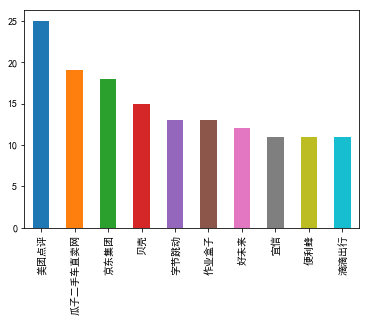

In [5]:
company_count = df.companyShortName.value_counts()[:10]
company_count.plot.bar();

招聘数量排名前十的公司中，美团点评第一位。

### 什么样的学历能够胜任数据分析呢？

市场上对数据分析岗位到底要求什么学历呢？我们可以统计下不同招聘不同学历岗位的数量来得到我们想要的结论。

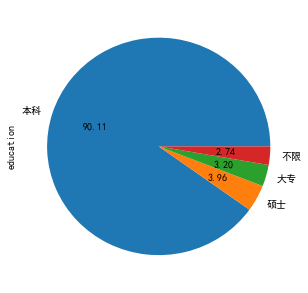

In [6]:
df.education.value_counts().plot.pie(figsize=(5, 5), autopct="%.2f");

可以看到，对于数据分析岗位来说，绝大多数的公司要求的学历是本科即可。

### 几年工作经验更受市场欢迎呢？

我们来看下到底几年经验的数据分析师更受市场欢迎呢？

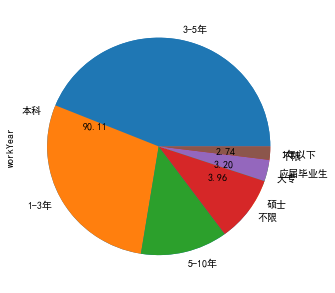

In [7]:
df.education.value_counts().plot.pie(figsize=(5, 5), autopct="%.2f");df.workYear.value_counts().plot.pie();

答案很明显，3-5年的数据分析师最受市场欢迎。

### 北京哪个区的数据分析岗位机会最多？

由于我们抓取的是北京地区的数据分析岗位招聘情况，所以这里来统计下哪个区的机会最多。

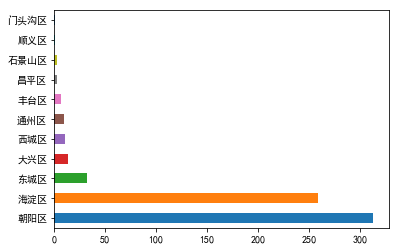

In [8]:
data = df.district.value_counts().plot.barh();

可以看到，朝阳区的数据分析岗位机会最多，我们可以将它可视化在地区图中。

In [15]:
from pyecharts import Geo

data = df.district.value_counts().to_dict()

geo = Geo(
    "北京",
    "job",
    title_color="#fff",
    title_pos="center",
    width=600,
    height=400,
    background_color="#404a59",
)
attr, value = geo.cast(data)

geo.add(
    "",
    attr,
    value,
    visual_range=[0, 150],
    maptype="北京",
    visual_text_color="#fff",
    symbol_size=15,
    is_visualmap=True,

)
geo

### 不同工作年限的数据分析师是什么收入水平？

如果要从事数据分析师的话，我们有必要了解下不同工作年限的这个岗位的收入水平（尤其是5年后）。

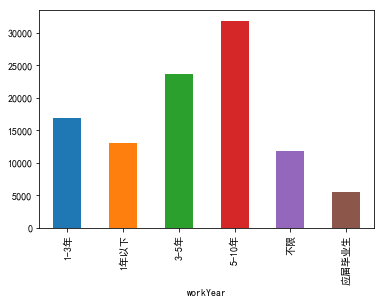

In [16]:
def calculate_salary_mean(salary_str):
    salary_sum = 0
    
    salary_list= salary_str.upper().replace("K", "000").split("-")
    
    for i in salary_list:
        salary_sum += int(i)
    
    return salary_sum / len(salary_list)

# 计算每条招聘信息中新增的平均薪资
df["salary_mean"] = df["salary"].map(lambda x: calculate_salary_mean(x))

work_year_salary_mane = df.groupby("workYear")["salary_mean"].mean()

plt.figure()

work_year_salary_mane.plot.bar();

对于数据分析岗位来说，应届毕业生平均可以拿到 6000+ 的薪资，工作 5 年以上可以拿到 30000+ 的薪资。